In [19]:
##Defining the SLAs
##Common part
retrievalPrice = 75 ##Price which CMP pays for the retrieval of a data item from the source
#gapTime = 0.75 ##This valiable is defining the caching strategy; 0 means full coverage, inf means reactive
##gapTime is measured after the end of freshness period of SLA1
gapTime = 0

n = 10 #number of SLAs

freshPeriodList = []
lambdaList = []
requestPriceList = []
penaltyList = []
planningPeriod = 600



# freshPeriodList = [0.1, 0.35, 0.48, 0.55, 0.67]
# lambdaList = [8,12,18,25,40]
# requestPriceList = [180,130,80, 40,20]
# penaltyList = [190, 150, 100, 50, 30]
# planningPeriod = 600


arrivalTimes_SLA_dict = {}
eventInterArrivalTimes_SLA_dict = {}


In [21]:
#randomly populating freshness periods
import random

freshPeriodList = []
lambdaList = []
requestPriceList = []
penaltyList = []


for i in range(n):
    freshPeriodList.append(random.random()*10)
    lambdaList.append(random.random())
    requestPriceList.append(random.randint(1,100))
    penaltyList.append(random.randint(1,100))
    
freshPeriodList.sort()
lambdaList.sort()
requestPriceList.sort()
penaltyList.sort()

print("freshPeriodList", freshPeriodList)
print("lambdaList", lambdaList)
print("requestPriceList", requestPriceList)
print("penaltyList", penaltyList)


freshPeriodList [0.6448232697244238, 0.8128753781358944, 2.342819879561345, 2.607543214834206, 6.2554929473806204, 7.7242765456733045, 7.73583888757325, 8.547791291549917, 8.898746917070511, 9.919899534896238]
lambdaList [0.043570886756961746, 0.054058718222955604, 0.10097012534031358, 0.2532067436041846, 0.4556322865399506, 0.5131150276894617, 0.666269566527107, 0.8005306491368376, 0.8071746640295213, 0.860469435571796]
requestPriceList [6, 22, 28, 32, 36, 55, 59, 70, 70, 80]
penaltyList [1, 24, 33, 35, 59, 64, 71, 86, 91, 91]


In [3]:
#creating dictionaries for holding arrival times for each SLA
for i in range(1, len(freshPeriodList)+1):
    arrivalTimes_SLA_dict[i] = []
    eventInterArrivalTimes_SLA_dict[i] = []

In [4]:
arrivalTimes_SLA_dict

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

In [5]:
eventInterArrivalTimes_SLA_dict

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

In [6]:
##generator of events
import random
import math
import statistics
import matplotlib.pyplot as plt
from datetime import datetime

arrivalTimesAll = []
eventArrivalTimesSLA1 = []
eventInterArrivalTimesSLA1 = []

eventArrivalTimesSLA2 = []
eventInterArrivalTimesSLA2 = []

eventArrivalTimesSLA3 = []
eventInterArrivalTimesSLA3 = []

def generateArrivals(lambdaSLA, planningPer):
    lambdaSLA1 = lambdaSLA #number of events per second
    planningPeriod = planningPer # we will be generating for this number of seconds
    eventID = 0
    eventIDs = [] #array containing the counter of events
    eventInterArrivalTimes = [] #array with inter-arrival times
    eventArrivals = [] #array with real times of event arrival
    eventArrivalTime = 0 ##time of a current event
    while eventArrivalTime < planningPeriod:

        #Get a random probability value from the uniform distribution's PDF
        n = random.random()
        #print("n:", n)

        #Generate the inter-event time from the exponential distribution's CDF using the Inverse-CDF technique
        InterArrivalTime = -math.log(1.0 - n) / lambdaSLA1


        #Add the inter-event time to the running sum to get the next absolute event time
        eventArrivalTime = eventArrivalTime + InterArrivalTime
        if eventArrivalTime > planningPeriod:
            break
        eventIDs.append(eventID)
        eventInterArrivalTimes.append(InterArrivalTime)
        eventArrivals.append(eventArrivalTime)

        #print it all out
        #print(str(eventID) +',' + str(InterArrivalTime) + ',' + str(eventArrivalTime))
        eventID = eventID + 1
        
    
    return eventArrivals, eventInterArrivalTimes


In [7]:
# arrivalTimesSLA1, eventInterArrivalTimesSLA1 = generateArrivals(8.0, planningPeriod)
# arrivalTimesSLA2, eventInterArrivalTimesSLA2 = generateArrivals(12.0, planningPeriod)
# arrivalTimesSLA3, eventInterArrivalTimesSLA3 = generateArrivals(18.0, planningPeriod)
# #print(eventInterArrivalTimesSLA1)

In [8]:
#generating arrivals for all SLAs
for i in range(1, len(freshPeriodList)+1):
    arrivalTimes_SLA_dict[i], eventInterArrivalTimes_SLA_dict[i] = generateArrivals(lambdaList[i-1], planningPeriod)

In [9]:
def buildHist(eventInterArrivals):
    #plot the distribution of inter-arrival times
    fig = plt.figure()
    fig.suptitle('Distribution of inter-arrival times')
    plt.hist(eventInterArrivals, color = 'blue', edgecolor = 'black',bins = int(15))
    plt.xlabel('Time bins (ms)')
    plt.ylabel('Number of arrivals')
    plt.show()

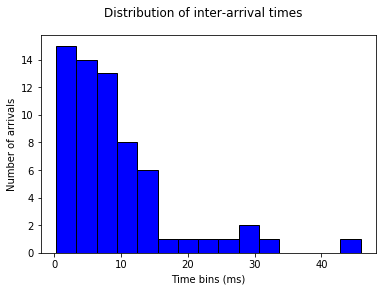

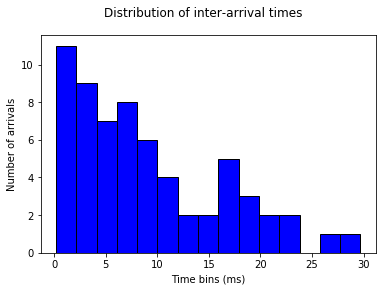

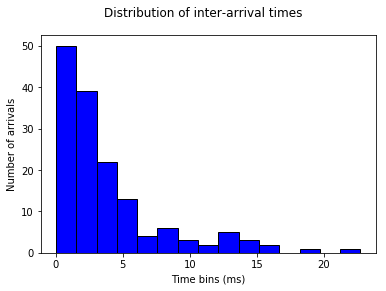

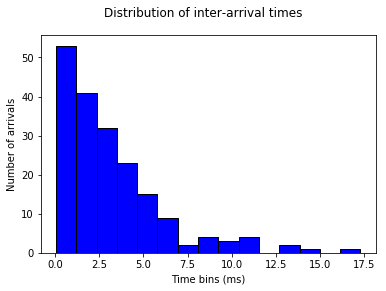

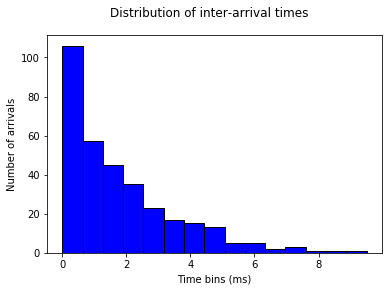

In [10]:
buildHist(eventInterArrivalTimes_SLA_dict[1])
buildHist(eventInterArrivalTimes_SLA_dict[2])
buildHist(eventInterArrivalTimes_SLA_dict[3])
buildHist(eventInterArrivalTimes_SLA_dict[4])
buildHist(eventInterArrivalTimes_SLA_dict[5])

In [11]:
for i in range(1, len(freshPeriodList)+1):
    for j in range(0, len(arrivalTimes_SLA_dict[i])):
        arrivalTimesAll.append((arrivalTimes_SLA_dict[i][j],i))

In [12]:
# take second element for sort
def takeFirst(arr):
    return arr[0]

arrivalTimesAll.sort(key=takeFirst)

In [13]:
#print(arrivalTimesAll)

In [14]:
### Now defining a function which will calculate the profit in a planning period
import numpy as np

#@np.vectorize
def gapRunner(gap):
    gapTime = gap
    print("gap Time", gapTime)
    RP = freshPeriodList[0] + gapTime
    print("RP = ", RP)
    
    print("start time: ", datetime.now())
    
    freshPeriodListLocal = freshPeriodList.copy()
    for i in range(0, len(freshPeriodListLocal)):
        if freshPeriodListLocal[i] > RP:
            freshPeriodListLocal[i] = RP
    print("freshPeriodListLocal:", freshPeriodListLocal)
    
    
    retrievalTimes = []  ##all retrievals
    
    retrievalTimes_SLA_dict = {} ##TRIGGERED RETRIEVALS by SLA
    for r in range(len(freshPeriodList)):
        retrievalTimes_SLA_dict[r+1] = []
    
    missTimes = [] ##all misses (without auto retrievals)
    autoRetrievalTimes = []
    retrievalTime = 0.0
    lastProcessedMiss = 0  
    missFlag = 0
    segmentFlag = 0

    SLAmiss = 0

    while retrievalTime < planningPeriod:
        #print("retrievalTime: ", retrievalTime)
        #print("while start time: ",datetime.now())
        
        retrievalTimes.append(retrievalTime)
        
        
        if missFlag > 0:
            missTimes.append(retrievalTime)
            retrievalTimes_SLA_dict[missFlag].append(retrievalTime)
            missFlag = 0
        else:
            autoRetrievalTimes.append(retrievalTime)        
      
        ##next retrieval time will happen when we have the end of freshness of SLA1 + gap, or when a miss will happen, 
        #What comes earlier?      
        
        ##Is it an SLA1 miss or SLAn miss?
        plannedRetrievalTime = retrievalTime + freshPeriodList[0] + gapTime
        #print("plannedRetrievalTime: ", plannedRetrievalTime)
        #expiryTimeAll = [retrievalTime + freshPeriodListLocal[0], retrievalTime + freshPeriodListLocal[1], retrievalTime + freshPeriodListLocal[2]] 
        
        expiryTimeAll = []
        
        for i in range(0, len(freshPeriodListLocal)):
            expiryTimeAll.append(retrievalTime + freshPeriodListLocal[i])

        #is there a request between expiryTime and plannedRetrievalTime?
        if lastProcessedMiss == len(arrivalTimesAll) -1: ##if the last miss was processed, than this is not needed            
            break
        ##Are there misses?
        for i in range(lastProcessedMiss+1,len(arrivalTimesAll)):
            #print("for start time: ",datetime.now())
            if arrivalTimesAll[i][0] > plannedRetrievalTime:
                lastProcessedMiss = i
                break
            
            if (arrivalTimesAll[i][0] >= expiryTimeAll[arrivalTimesAll[i][1]-1]) and (arrivalTimesAll[i][0] < plannedRetrievalTime):             
                ## we have a miss   
                ##in which SLA?
                SLAmiss = arrivalTimesAll[i][1]
                ##in which segment did the miss happen?
                
                ##next retrieval time is now, as we got a miss
                retrievalTime = arrivalTimesAll[i][0]
                lastProcessedMiss = i
                missFlag = SLAmiss
                ##in which segment did the miss happen?
                
                break
                            
        if missFlag >=1:
            pass
        else:
            retrievalTime = plannedRetrievalTime
            #globalSegmentFlag = 0
            missFlag = 0
            
    ##Main statistics    
    
    missRates_SLA_dict = {}
    for m in range(len(freshPeriodList)):
        missRates_SLA_dict[m+1] = len(retrievalTimes_SLA_dict[m+1])/len(arrivalTimes_SLA_dict[m+1])
    
    hitRates_SLA_dict = {}
    for m in range(len(freshPeriodList)):
        hitRates_SLA_dict[m+1] = 1- missRates_SLA_dict[m+1]
        
    
    print('miss rates: ', missRates_SLA_dict)
    print(missRates_SLA_dict)
    
    print("hit rates:", hitRates_SLA_dict)
    print(hitRates_SLA_dict)
    
    ##Penalties (losses)    
    
    PenaltyAll = 0
    Penalties_SLA_dict = {}
    for p in range(len(freshPeriodList)):
        Penalties_SLA_dict[p+1] = len(retrievalTimes_SLA_dict[p+1]) * penaltyList[p]
        PenaltyAll +=Penalties_SLA_dict[p+1]
           
    print("Penalties by SLA")  
    print("penaltyAll:", PenaltyAll)        
    print(Penalties_SLA_dict)
     
    triggeredRetrievalsNumber = 0
    triggeredRetrievalsCostAll = 0
    triggeredRetrievals_Cost_SLA_dict = {}
    for t in range(len(freshPeriodList)):
        triggeredRetrievals_Cost_SLA_dict[t+1] = len(retrievalTimes_SLA_dict[t+1]) * retrievalPrice
        triggeredRetrievalsNumber += len(retrievalTimes_SLA_dict[t+1])
        triggeredRetrievalsCostAll +=triggeredRetrievals_Cost_SLA_dict[t+1]
      
 
    ##Auto retrievals (losses)
    numberAutoRetrievals = (len(autoRetrievalTimes))
    
#     print('miss retrievalTimes: ', len(retrievalTimesSLA1), len(retrievalTimesSLA2), len(retrievalTimesSLA3))
    
    print('numberAutoRetrievals: ', numberAutoRetrievals)
    
    all_retrievals =  numberAutoRetrievals + triggeredRetrievalsNumber
    
    #all_retrievals = numberAutoRetrievals + len(retrievalTimesSLA1) + len(retrievalTimesSLA2) + len(retrievalTimesSLA3) 
    print('all retrievals number:', all_retrievals )
    period_duration = 6000/all_retrievals
    print("Period duration: ", period_duration)
    
    autoRetrievalsCost =  numberAutoRetrievals * retrievalPrice
    
    RequestIncomeAll = 0
    for r in range(len(freshPeriodList)):
        RequestIncomeAll += len(arrivalTimes_SLA_dict[r+1]) * requestPriceList[r]
               
    
    print("RequestIncomeAll", RequestIncomeAll)    
    print("autoRetrievalsCost", autoRetrievalsCost)

    totalProfit = RequestIncomeAll - autoRetrievalsCost - triggeredRetrievalsCostAll - PenaltyAll
    
    print("End time: ",datetime.now())
    
    return totalProfit

In [15]:
gapRunner(0.55)

gap Time 0.55
RP =  1.99620804889399
start time:  2020-11-13 17:11:32.355678
freshPeriodListLocal: [1.44620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399, 1.99620804889399]
miss rates:  {1: 0.203125, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.203125, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.796875, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.796875, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 52
{1: 52, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  290
all retrievals number: 303
Period duration:  19.801980198019802
RequestIncomeAll 205336
autoRetrievalsCost 21750
End time:  2020-11-13 17:11:32.359677


182559

In [16]:
gapRunner(0.15)

gap Time 0.15
RP =  1.5962080488939898
start time:  2020-11-13 17:11:32.366177
freshPeriodListLocal: [1.44620804889399, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898, 1.5962080488939898]
miss rates:  {1: 0.09375, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.09375, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.90625, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.90625, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 24
{1: 24, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  371
all retrievals number: 377
Period duration:  15.915119363395226
RequestIncomeAll 205336
autoRetrievalsCost 27825
End time:  2020-11-13 17:11:32.367675


177037

In [17]:
g = 0
resultList = []
while g <= 11.0:    
    resultList.append((g, gapRunner(g)))
    g += 0.05

gap Time 0
RP =  1.44620804889399
start time:  2020-11-13 17:11:32.377177
freshPeriodListLocal: [1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399, 1.44620804889399]
miss rates:  {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 0
{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  415
all retrievals number: 415
Period duration:  14.457831325301205
RequestIncomeAll 205336
autoRetrievalsCost 31125
End time:  2020-11-13 17:11:32.379680
gap Time 0.05
RP =  1.49620804889399
start time:  2020-11-13 17:11:32.379680
freshPeriodListLocal: [

miss rates:  {1: 0.59375, 2: 0.38095238095238093, 3: 0.0728476821192053, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.38095238095238093, 3: 0.0728476821192053, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.6190476190476191, 3: 0.9271523178807947, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.40625, 2: 0.6190476190476191, 3: 0.9271523178807947, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 970
{1: 152, 2: 312, 3: 506, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  109
all retrievals number: 182
Period duration:  32.967032967032964
RequestIncomeAll 205336
autoRetrievalsCost 8175
End time:  2020-11-13 17:11:32.535679
gap Time 2.2
RP =  3.64620804889399
start time:  2020-11-13 17:11:32.535679
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 3.64620804889399, 3.64620804889399, 3.64620804889399, 3.64620804889399, 3.6

Penalties by SLA
penaltyAll: 1530
{1: 160, 2: 312, 3: 1058, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  83
all retrievals number: 170
Period duration:  35.294117647058826
RequestIncomeAll 205336
autoRetrievalsCost 6225
End time:  2020-11-13 17:11:32.568179
gap Time 2.6999999999999984
RP =  4.146208048893988
start time:  2020-11-13 17:11:32.568179
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 4.146208048893988, 4.146208048893988, 4.146208048893988, 4.146208048893988, 4.146208048893988, 4.146208048893988, 4.146208048893988]
miss rates:  {1: 0.640625, 2: 0.3968253968253968, 3: 0.17218543046357615, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.640625, 2: 0.3968253968253968, 3: 0.17218543046357615, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.359375, 2: 0.6031746031746033, 3: 0.8278145695364238, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.359375, 2: 0.6031746031746033, 3

RP =  5.846208048893982
start time:  2020-11-13 17:11:32.721680
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 4.8885315051478475, 5.660004327449652, 5.846208048893982, 5.846208048893982, 5.846208048893982, 5.846208048893982, 5.846208048893982]
miss rates:  {1: 0.59375, 2: 0.5238095238095238, 3: 0.2251655629139073, 4: 0.06842105263157895, 5: 0.015197568389057751, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.5238095238095238, 3: 0.2251655629139073, 4: 0.06842105263157895, 5: 0.015197568389057751, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.47619047619047616, 3: 0.7748344370860927, 4: 0.9315789473684211, 5: 0.9848024316109423, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.40625, 2: 0.47619047619047616, 3: 0.7748344370860927, 4: 0.9315789473684211, 5: 0.9848024316109423, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 3078
{1: 152, 2: 429, 3: 1564, 4: 663, 5: 270, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0

miss rates:  {1: 0.578125, 2: 0.5396825396825397, 3: 0.23841059602649006, 4: 0.07368421052631578, 5: 0.0182370820668693, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.578125, 2: 0.5396825396825397, 3: 0.23841059602649006, 4: 0.07368421052631578, 5: 0.0182370820668693, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.421875, 2: 0.46031746031746035, 3: 0.7615894039735099, 4: 0.9263157894736842, 5: 0.9817629179331308, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.421875, 2: 0.46031746031746035, 3: 0.7615894039735099, 4: 0.9263157894736842, 5: 0.9817629179331308, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 3284
{1: 148, 2: 442, 3: 1656, 4: 714, 5: 324, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  16
all retrievals number: 143
Period duration:  41.95804195804196
RequestIncomeAll 205336
autoRetrievalsCost 1200
End time:  2020-11-13 17:11:32.753681
gap Time 4.849999999999991
RP =  6.2962080488939804
start time:  2020-11-13 17:11:32.754181
freshPer

{1: 152, 2: 468, 3: 1656, 4: 765, 5: 540, 6: 280, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  2
all retrievals number: 142
Period duration:  42.25352112676056
RequestIncomeAll 205336
autoRetrievalsCost 150
End time:  2020-11-13 17:11:32.909683
gap Time 6.449999999999985
RP =  7.896208048893975
start time:  2020-11-13 17:11:32.909683
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 4.8885315051478475, 5.660004327449652, 6.3126499912663405, 6.736372914924793, 7.896208048893975, 7.896208048893975, 7.896208048893975]
miss rates:  {1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.030395136778115502, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.030395136778115502, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.96

Period duration:  42.25352112676056
RequestIncomeAll 205336
autoRetrievalsCost 75
End time:  2020-11-13 17:11:32.940186
gap Time 6.849999999999984
RP =  8.296208048893973
start time:  2020-11-13 17:11:32.940186
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 4.8885315051478475, 5.660004327449652, 6.3126499912663405, 6.736372914924793, 8.296208048893973, 8.296208048893973, 8.296208048893973]
miss rates:  {1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.9665653495440729, 6: 0.9872122762148338, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099,

Period duration:  42.25352112676056
RequestIncomeAll 205336
autoRetrievalsCost 75
End time:  2020-11-13 17:11:33.097185
gap Time 8.499999999999986
RP =  9.946208048893975
start time:  2020-11-13 17:11:33.097185
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 4.8885315051478475, 5.660004327449652, 6.3126499912663405, 6.736372914924793, 8.632656273142594, 9.356907175197815, 9.364798663004377]
miss rates:  {1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.9665653495440729, 6: 0.9872122762148338, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099,

miss rates:  {1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.9665653495440729, 6: 0.9872122762148338, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.9665653495440729, 6: 0.9872122762148338, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 3915
{1: 152, 2: 468, 3: 1656, 4: 765, 5: 594, 6: 280, 7: 0, 8: 0, 9: 0, 10: 0}
numberAutoRetrievals:  1
all retrievals number: 142
Period duration:  42.25352112676056
RequestIncomeAll 205336
autoRetrievalsCost 75
End time:  2020-11-13 17:11:33.284688
gap Time 10.25000000000001
RP =  11.6962080

start time:  2020-11-13 17:11:33.314689
freshPeriodListLocal: [1.44620804889399, 2.0779471898556237, 3.3632618447125173, 4.8885315051478475, 5.660004327449652, 6.3126499912663405, 6.736372914924793, 8.632656273142594, 9.356907175197815, 9.364798663004377]
miss rates:  {1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
{1: 0.59375, 2: 0.5714285714285714, 3: 0.23841059602649006, 4: 0.07894736842105263, 5: 0.03343465045592705, 6: 0.01278772378516624, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
hit rates: {1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.9665653495440729, 6: 0.9872122762148338, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
{1: 0.40625, 2: 0.4285714285714286, 3: 0.7615894039735099, 4: 0.9210526315789473, 5: 0.9665653495440729, 6: 0.9872122762148338, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Penalties by SLA
penaltyAll: 3915
{1: 152, 2: 468, 3: 1656, 4: 765, 

In [18]:
print(resultList)

[(0, 174211), (0.05, 175178), (0.1, 176149), (0.15000000000000002, 177037), (0.2, 177945), (0.25, 178667), (0.3, 179433), (0.35, 180179), (0.39999999999999997, 180652), (0.44999999999999996, 181442), (0.49999999999999994, 181939), (0.5499999999999999, 182559), (0.6, 183056), (0.65, 183502), (0.7000000000000001, 184030), (0.7500000000000001, 184346), (0.8000000000000002, 184996), (0.8500000000000002, 185403), (0.9000000000000002, 185418), (0.9500000000000003, 185823), (1.0000000000000002, 186293), (1.0500000000000003, 186572), (1.1000000000000003, 186973), (1.1500000000000004, 187182), (1.2000000000000004, 187343), (1.2500000000000004, 187555), (1.3000000000000005, 187742), (1.3500000000000005, 188146), (1.4000000000000006, 188174), (1.4500000000000006, 188540), (1.5000000000000007, 188906), (1.5500000000000007, 189017), (1.6000000000000008, 189124), (1.6500000000000008, 189352), (1.7000000000000008, 189533), (1.7500000000000009, 189850), (1.800000000000001, 190207), (1.850000000000001,